# **COMP3670/6670 Assignment 3 - GMM**
---

**Enter Your Student ID:**

**Your Name:**  
    

**Submit:** You can write your answers in this file and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Otherwise, you can write your programming questions in this file, and submit two files, 'uXXXXXXX.ipynb' for programming and 'uXXXXXXX.pdf' for theory. Please submit them separately instead of a zip file.
    
**Enter Discussion Partner IDs Below:**
- <Enter ID 1>
- <Enter ID 2>
- <Enter ID 3>
    

**Programming Section**
- 1 = 20%
- 2 = 20%
- 3 = 20%
- 4 = 10%
- 5 = 10%
- 6 = 20%

---


**PROGRAMMING SECTION**
---


For all of the following, program the solution yourself. Don't just call a library function that does the whole question for you, or you'll get zero (no, that doesn't mean you can't use any library functions, but it does mean that you have to show you understand how to compute the answer yourself).

-----------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  #This is for 3d scatter plots.
import math
import random
import functools

import time
import sys

import scipy.signal
import os
from matplotlib.pyplot import imread
! pip install patchify
from patchify import patchify


We're going to implement an algorithm to model data with a mixture of gaussians. 

Remember the simplified EM algorithm in assignment 2 for k-means? Well, we're going to implement something similar.

The more complex aspect of this all is that your program must also correctly estimate the covariance matrices of the 2-dimensional gaussian components involved, as well as their means.

Not only this, but the "distance" of each of your data points (a row $d_i$ of $D$) from a gaussian $k$, is the probability of that point given that gaussian $p(d_i \mid k)$. 

Run the below cell to load the data we'll be using.

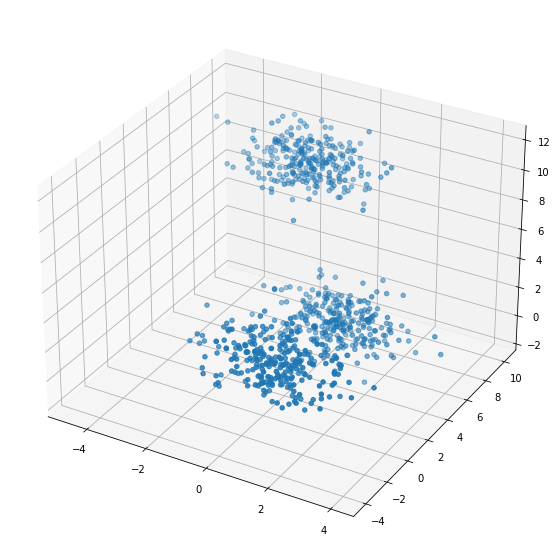

In [2]:
X = np.load("./data.npy")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
plt.show()

First off, some definitions:

$X$ is a dataset contains 800 data. Each data has 3 dimensions. They are represented by a three dimensional Gaussian Mixture Model.

$K$ is the total number of gaussians. This is just like the $K$ means you had for k-means in assignment 2. Each gaussian is named $k$, where $k$ is the unique number associated with that gaussian. Each $k$ has a mean and covariance matrix associated with it. This allows you to construct a gaussian which is just a formula which can be used to generate data points or to compute the probability that a given data point is generated from this gaussian (look up generative models if you're curious to learn more). For this purpose, you can use np.random.multivariate_normal().

$\Sigma$ is a list of covariance matrices $\Sigma_k \in \mathbb{R}^{m \times m}$, which are symmetric positive semidefinite matrices.

$\mu$ is a list of means, each one $\mu_k \in \mathbb{R}^{m}$ associated with gaussian $k$.

$N$ is the total number of datapoints.

$responsibilities \in [0, 1]^{N \times K}$ is a matrix. Every column $k$ of $responsibilities$ is associated with the $k^{th}$ gaussian. Each element $r_{ik}$ of the $k^{th}$ column is the probability of the $i^{th}$ datapoint $x_i$ (the $i^{th}$ row of $X$) given the gaussian $k$.

$N_k$ is the sum of the $k^{th}$ column of $responsibilities$. In other words, there is one $N_k$ for each gaussian. $N_k = \sum_i r_{ik}$.

$\pi$ is a list of probabilies, 1 associated with each gaussian. $\pi_k$ is the probability of gaussian $k$. $\pi_k = \frac{N_k}{N}$.

---

   **TASK 1:** Complete the below function to initialise your parameters. You will need to generate:
   1. A list $\mu$ of $K$ means, each of which is in $\mathbb{R}^{m}$.
   2. A list $\Sigma$ of $K$ covariance matrices in $\mathbb{R}^{m \times m}$. Remember, covariance matrices must be symmetric positive semidefinite.
   3. A list $\pi$ of $K$ probabilities $\pi_k$. They should be initialised at $\frac{1}{K}$ (uniformly distributed at first).

Do not hard code parameters. You should generate them with some randomness, and your code must work for any $m$, $k$ and $N$.

You need to intelligently select $\mu_k$ just like you did with k-means. Poorly initialised parameters may result in an entirely broken EM algorithm.

---

In [3]:
def initialise_parameter(K, X):
    state = True
    while state:
        C = X[np.random.choice(X.shape[0], K)]
        centre = np.mean(X)
        N, m = np.shape(X)
        n = 0
        distance = np.zeros(N)
        while n < N:
            distance[n] = np.linalg.norm(centre - X[n,:])
            n += 1
        distance_m = np.mean(distance)
        a = 0
        state_1 = True
        while a < K-1:
            b = a + 1
            while b < K:
                if abs(C[a,0]-C[b,0]) > distance_m/2 and abs(C[a,1]-C[b,1]) > distance_m/2 and abs(C[a,2]-C[b,2]) > distance_m/2:
                    state_1 = False
                    break
                else:
                    b += 1
            a += 1
        if state_1:
            state = False
    return C


def E_step_k(C, X):
    #get the dimensions of the given matrices;
    m = np.shape(X)[0]
    o = np.shape(C)[0]
    # Initialise the asked matrix;
    L = np.zeros(np.shape(X))
    # Loop to get the centroid of each point;
    a = 0
    while a < m:
        # Get the distances between each point and centroid;
        b = 0
        norm = np.zeros(o)
        c = 0
        while b < o:
            dist = C[b, :] - X[a, :]
            norm[b] = np.linalg.norm(dist)
            # Assign the centroid with the smallest distance to the point to the corresponding row of
            if norm[b] < norm[c]:
                c = b
            b += 1
        L[a, :] = C[c, :]
        a += 1
    return L


def M_step_k(C, X, L):
    # Get shapes of matrices;
    a = np.shape(C)[0]
    c = np.shape(X)[0]
    # Classify the points by their centroid, save their amount and sum, get the mean value of every set of points after classification;
    # Initialize the amount and sum:
    amount = np.zeros(a)
    summation = np.zeros(np.shape(C))
    # Classify:
    index_0 = 0
    while index_0 < c:
        index_1 = 0
        while index_1 < a:
            if (L[index_0] == C[index_1]).all():
                amount[index_1] += 1
                summation[index_1, :] += np.copy(X[index_0, :])
                break
            else:
                index_1 += 1
        index_0 += 1
    # Get the centroid of different sets:
    D = np.copy(C)
    index_0 = 0
    while index_0 < a:
        if amount[index_0] != 0:
            D[index_0] = summation[index_0] / amount[index_0]
        else:
            D[index_0] = 0;
        index_0 += 1
    return D


def kmeans(X, m, threshold):
    C = initialise_parameter(m, X)
    loss_1 = 0
    L = E_step_k(C, X)
    loss_0 = loss_k(X, L)
    while abs(loss_1 - loss_0) >= threshold:
        loss_0 = loss_1
        C = M_step_k(C, X, L)
        L = E_step_k(C, X)
        loss_1 = loss_k(X, L)
    return C, L


def loss_k(X, L):
    a = np.shape(X)[0]
    i = 0
    diff = 0
    while i < a:
        diff += math.pow(np.linalg.norm(X[i] - L[i]), 2)
        i += 1
    return diff

In [4]:
def initialise_parameters(X, K):
    # YOUR CODE HERE

    C, L = kmeans(X, K, 1e-6)
    # Categorize the dataset according to clusters:
    N = np.shape(L)[0]
    amount = np.zeros(K).astype(dtype=int)
    cluster = []
    i = 0
    while i < K:
        cluster.append(np.zeros(np.shape(X)))
        i += 1
    n = 0
    while n < N:
        k = 0
        while k < K:
            if (L[n] == C[k]).all():
                cluster[k][amount[k]] = X[n]
                amount[k] += 1
                break
            else:
                k += 1
        n += 1
    i = 0
    while i < K:
        cluster[i] = cluster[i][0:amount[i], :]
        i += 1
    # Finish Categorizing;

    mu = []
    sigma = []
    pi = []
    i = 0
    while i < K:
        # Generate mu:
        mu.append(C[i, :])
        # Generate sigma:
        sigma.append(np.cov(np.transpose(cluster[i])))
        # Generate pi:
        pi.append(1 / K)
        i += 1
    return sigma, mu, pi


K = 4
sigma, mu, pi = initialise_parameters(X[:, :3], K)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [array([[ 0.77987734,  0.22516878,  0.16234136],
       [ 0.22516878,  0.59877382, -0.08104115],
       [ 0.16234136, -0.08104115,  0.82448708]]), array([[ 0.95948731,  0.00507762, -0.00605851],
       [ 0.00507762,  1.00742525,  0.02719949],
       [-0.00605851,  0.02719949,  0.88484001]]), array([[ 0.76515983,  0.14258755,  0.15351991],
       [ 0.14258755,  0.67020697, -0.11461199],
       [ 0.15351991, -0.11461199,  0.81986519]]), array([[ 0.88255597,  0.04793379, -0.01274732],
       [ 0.04793379,  0.96983727, -0.00254907],
       [-0.01274732, -0.00254907,  1.02511483]])]

Mu: 
 [array([ 1.40050286, -2.04546838,  2.64574301]), array([-1.25357647,  7.77508651,  9.36231926]), array([ 0.25312991, -0.85537774,  3.25254232]), array([1.04197159, 4.23083238, 1.8630967 ])]

Pi: 
 [0.25, 0.25, 0.25, 0.25]


$E\_step$ computes the matrix $responsibilities \in [0, 1]^{N \times K}$, where $N$ is the number of data points, and $K$ is the number of gaussians you're attempting to cluster the data with. Each gaussian will be associated with a column of $responsibilities$. As your algorithm runs, each row represents a data point $x_i$, and each column of that row will contain the probability that $x_i$ came from that gaussian, $p(x_i \mid k)$, signifying the extent to which this datapoint $x_i$ has been assigned to the gaussian associated with that column. 

---

**TASK 2:** Implement $E\_step(\pi, \mu, \Sigma, X) = responsibilities$, which updates the $responsibilities$ matrix.

Remember, which gaussian a datapoint is assigned to depend on the probability of that datapoint given that gaussian.

**HINT:** 
- Each element of responsibilities $r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j \Sigma_j)}$, where $x_i$ is the $i^{th}$ row of $X$.
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
- Use $multivariate\_normal.pdf(x, \mu_k, \Sigma_k)$

---

In [5]:
def E_step(pi, mu, sigma, X):
    # YOUR CODE HERE
    N = np.shape(X)[0]  # The number of data points;
    K = np.shape(pi)[0]  # The number of gaussians;
    r = np.zeros([N, K])
    i = 0
    mn = []
    while i < K:
        mn.append(1)
        i += 1
    i = 0
    while i < N:
        k = 0
        j = 0
        denom = 0
        while j < K:
            mn[j] = pi[j] * scipy.stats.multivariate_normal.pdf(X[i], mu[j], sigma[j])
            denom += mn[j]
            j += 1
        while k < K:
            r[i, k] = pi[k] * mn[k] / denom
            k += 1
        i += 1
    return r


responsibilities = E_step(pi, mu, sigma, X[:, :3])
print(responsibilities)

[[2.49799475e-01 3.43416648e-41 2.00524792e-04 3.07428196e-12]
 [4.33715995e-79 2.50000000e-01 1.39844425e-50 2.17544268e-17]
 [2.36208757e-12 1.74771034e-18 3.73131648e-06 2.49996269e-01]
 ...
 [2.45043496e-01 4.55393806e-34 4.95650245e-03 1.44690466e-09]
 [1.17828985e-81 2.50000000e-01 9.34780399e-54 3.00217327e-20]
 [5.77152684e-18 1.83293421e-16 4.27841937e-09 2.49999996e-01]]


---

**TASK 3:** Implement $M\_step(responsibilities, X) = \mu, \Sigma, \pi$ which returns the updated means and covariances for all of the $k$ gaussians, along with the priors $\pi$.

**HINT:** 
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html

---

In [6]:
def M_step(r, X):
    # YOUR CODE HERE
    N, K = np.shape(r)
    # Get Nk:
    Nk = sum(r)
    # Get mu:
    mu = []
    k = 0
    while k < K:
        sum_1 = 0
        n = 0
        while n < N:
            sum_1 += r[n][k] * X[n]
            n += 1
        mu.append(sum_1 / Nk[k])
        k += 1

    # Get sigma:
    k = 0
    sigma = []
    pi = []
    while k < K:
        sum_1 = 0
        n = 0
        while n < N:
            sum_1 += r[n][k] * np.outer(X[n] - mu[k], X[n] - mu[k])
            n += 1
        sigma.append(sum_1 / Nk[k])
        pi.append(Nk[k] / N)
        k += 1
    return mu, sigma, pi


mu, sigma, pi = M_step(responsibilities, X[:, :3])
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [array([[ 0.82733321,  0.18670707,  0.13771337],
       [ 0.18670707,  0.62304474, -0.07382803],
       [ 0.13771337, -0.07382803,  0.81885092]]), array([[ 0.95588029,  0.00505873, -0.00603561],
       [ 0.00505873,  1.00363702,  0.02709658],
       [-0.00603561,  0.02709658,  0.88151324]]), array([[ 0.83880721,  0.08529222,  0.14508142],
       [ 0.08529222,  0.66065409, -0.11437438],
       [ 0.14508142, -0.11437438,  0.80294967]]), array([[ 0.88206086,  0.05807546, -0.02587269],
       [ 0.05807546,  0.98989669, -0.02147431],
       [-0.02587269, -0.02147431,  1.04630421]])]

Mu: 
 [array([ 1.37003038, -2.03507961,  2.64061641]), array([-1.25357653,  7.77508685,  9.36231948]), array([ 0.35082069, -0.95137958,  3.2214393 ]), array([1.0372947 , 4.22024707, 1.87210691])]

Pi: 
 [0.04594340334251381, 0.08312499044073407, 0.03745705045371822, 0.08347455576303385]


---

**TASK 4:** Implement $classify(\pi, \mu, \Sigma, x) = k$ which takes an unknown example $x \in \mathbb{R}^{m}$, the means $\mu$ and covariance matrices $\Sigma$ and the priors $\pi$, and returns $k$, the number of the gaussian which maximises the probability of $x$.

In other words, ${arg max}_k \left(p(x \mid \mu_k, \Sigma_k)\pi_k \right)$.

---

In [7]:
def classify(pi, mu, sigma, x):
    # YOUR CODE HERE
    K = np.shape(pi)[0]
    probability = np.zeros(K)
    k = 0
    n = 0
    while k < K:
        probability[k] = pi[k]*scipy.stats.multivariate_normal.pdf(x,mu[k],sigma[k])
        k += 1
    n = np.argmax(probability)
    return n


print(classify(pi, mu, sigma, X[270, :3]))

3


---

**TASK 5:** Implement $EM(X, K, iterations) = \mu, \Sigma, \pi$ which: 
1. takes a dataset $X \in \mathbb{R}^{N \times m}$ and $K$, an integer indicating how many gaussians will be used to cluster the data, and $iterations$ the number of iterations to be performed.
2. uses all of the functions you completed above to initialise parameters and find the optimal means $\mu$, covariances $\Sigma$ and priors $\pi$ to cluster the data points (a gaussian mixture model).

---


Sigma: 
 [array([[ 1.09086211, -0.13401864, -0.0064875 ],
       [-0.13401864,  0.92695865,  0.07261178],
       [-0.0064875 ,  0.07261178,  0.89211682]]), array([[ 0.95588034,  0.00505886, -0.00603552],
       [ 0.00505886,  1.00363642,  0.02709615],
       [-0.00603552,  0.02709615,  0.88151302]]), array([[ 0.88083782,  0.05748841, -0.02404153],
       [ 0.05748841,  1.00459079, -0.01578258],
       [-0.02404153, -0.01578258,  1.04363429]])]

Mu: 
 [array([ 0.91179115, -1.55078509,  2.90477748]), array([-1.25357658,  7.77508708,  9.36231963]), array([1.037635  , 4.21588281, 1.87002698])]

Pi: 
 [1.6076654058629854e-15, 1.5018478365612586e-15, 1.7571620680744844e-15]


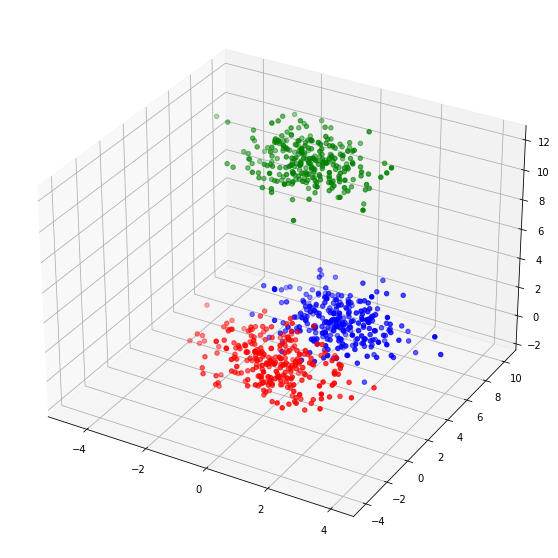

In [8]:
def EM(X, K, iterations):
    # YOUR CODE HERE
    sigma, mu, pi = initialise_parameters(X, K)
    i = 0
    while i < iterations:
        responsibilities = E_step(pi, mu, sigma, X)
        mu, sigma, pi = M_step(responsibilities, X)
        i += 1
    return mu, sigma, pi


#Test code. Leave it aloooooone!
iterations = 30
K = 3
mu_1, sigma_1, pi_1 = EM(X[:, :3], K, iterations)
print('\nSigma: \n', sigma_1)
print('\nMu: \n', mu_1)
print('\nPi: \n', pi_1)


def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)


colours = ['r', 'g', 'b']
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for k in range(K):
    cluster = allocator(pi_1, mu_1, sigma_1, X[:, :3], k)
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], c=colours[k])
plt.show()

---
**Task 6**: Image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics. In this task, we are going to implement a simple image segmentation algorithm using GMM.

The *image_segmentation* function should satisfy the following specifications:
* Inputs:
    - image: the image to be segmented. Type: np.ndarray
    - K: the number of gaussians.
    - iterations: the number of iterations of EM algorithm.
* Return:
    - a matrix, each element of this matrix corresponds to the class of pixels of the input image matrix. Type: np.ndarray. dtype: np.int32.
    - For an image with shape (78,78,3), the shape of returned matrix should be (78,78).

Make sure your code can run within 3 mins.

**Read more:** https://en.wikipedia.org/wiki/Image_segmentation

**Hints:** Remember to use the functions you defined above.

---

Let's load the image to be segmented first.

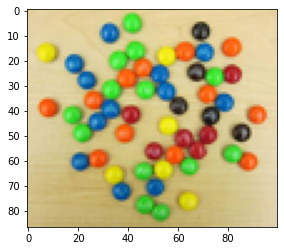

In [9]:
image = plt.imread('mandm.png')
plt.imshow(image)
plt.show()

It takes 44.22205471992493 seconds to segement the image.


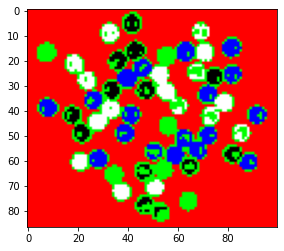

'Please run the code again if the result is wrong, Thank you.'

In [10]:
def image_segmentation(image, K, iterations):
    x = 0
    X,Y,C = np.shape(image)
    image_new = np.zeros([X,Y])
    n = 0
    X_new = np.zeros([X*Y,C])
    while x < X:
        y = 0
        while y < Y:
            X_new[n] = image[x,y,:]
            n += 1
            y += 1
        x += 1
    mu,sigma,pi = EM(X_new,K,iterations)

    x = 0
    n = 0
    while x < X:
        y = 0
        while y < Y:
            image_new[x,y] = classify(pi,mu,sigma,image[x,y])
            n+= 1
            y += 1
        x += 1
    image_new = image_new.astype(dtype=int)
    return image_new



# test code, leave it alone!
import time

start = time.time()
gmm_labels = image_segmentation(image, 5, 10)
end = time.time()
print(f'It takes {end - start} seconds to segement the image.')
colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]
segemented_image = np.zeros_like(image, dtype=np.int32)
m, n, _ = segemented_image.shape
for i in range(m):
    for j in range(n):
        segemented_image[i, j] = np.array(colors[gmm_labels[i, j]])
plt.imshow(segemented_image)
plt.show()

"""Please run the code again if the result is totally wrong, Thank you."""

Your answer should look like this, maybe with different colors:
![image](./segmented_image.png)